figures/google_trends_protests_in_iran.png
Event mapping: A = Green Movement (2009-06-01), B = Dey Protests (2017-12-28), C = Aban 98 (2019-11-01), D = Amini Protests (2022-09-01)


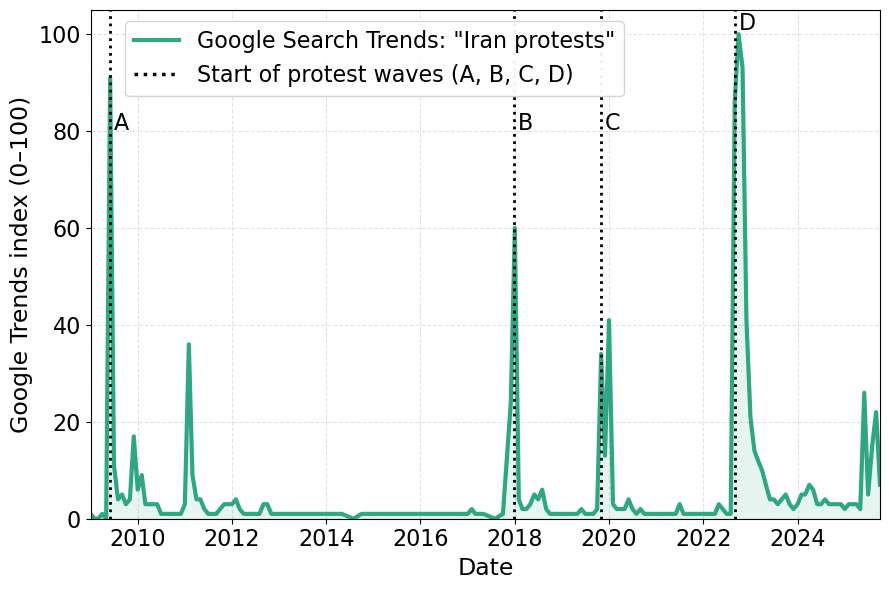

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from pathlib import Path
import re

# ---------- Helpers ----------
def load_google_trends(path):
    df = pd.read_csv(path, skiprows=2)
    # detect date column across locales
    date_col = None
    for cand in df.columns:
        if cand.lower() in ("month", "week") or "mois" in cand.lower() or "semaine" in cand.lower():
            date_col = cand; break
    if date_col is None:
        date_col = df.columns[0]
    series_col = [c for c in df.columns if c != date_col][0]
    df = df.rename(columns={date_col: "date", series_col: "interest"})
    df["date"] = pd.to_datetime(df["date"])
    df["interest"] = pd.to_numeric(df["interest"].replace({"<1":"0"}), errors="coerce")
    df = df.dropna(subset=["interest"]).sort_values("date")
    df = df[df["date"] >= "2009-01-01"]
    return df[["date","interest"]]

# ---------- Loader that handles single-series OR multi-country exports ----------
def load_trends_series(path, country=None):
    """
    Load Google Trends time series.
    - If the file is a typical single-series export (first col = Month/Week, second col = values),
      returns that series.
    - If the file contains multiple countries (first col = date, remaining = countries),
      pass `country` to select the column (case-insensitive).
    """
    df = pd.read_csv(path)

    # Try to detect the date column
    date_col = None
    for c in df.columns:
        cl = c.lower()
        if cl in ("month", "week", "date") or ("mois" in cl) or ("semaine" in cl):
            date_col = c
            break
    if date_col is None:
        # Also handle the common "Month" header after skiprows=2 exports
        # Try reading again with skiprows=2
        df = pd.read_csv(path, skiprows=2)
        for c in df.columns:
            cl = c.lower()
            if cl in ("month", "week", "date") or ("mois" in cl) or ("semaine" in cl):
                date_col = c
                break
        if date_col is None:
            date_col = df.columns[0]

    df = df.rename(columns={date_col: "date"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    # Replace "<1" with 0 and coerce numeric
    value_cols = [c for c in df.columns if c != "date"]
    for c in value_cols:
        df[c] = pd.to_numeric(df[c].replace({"<1": "0"}), errors="coerce")

    # If only one value column -> single series
    if len(value_cols) == 1 and country is None:
        return df[["date", value_cols[0]]].rename(columns={value_cols[0]: "interest"}), value_cols[0]

    # Multi-country: pick the requested country (case-insensitive contains match)
    if country is None:
        raise ValueError(
            "Multiple series detected. Please set `country='United States'` (or another column name). "
            f"Available columns: {value_cols[:10]}{'...' if len(value_cols)>10 else ''}"
        )

    # Try to match exact or fuzzy
    norm = lambda s: re.sub(r"\s+", " ", s.strip().lower())
    value_map = {norm(c): c for c in value_cols}
    key = norm(country)
    # exact first, then contains
    col_pick = value_map.get(key)
    if col_pick is None:
        # try contains
        cand = [v for k,v in value_map.items() if key in k]
        if cand:
            col_pick = cand[0]
        else:
            raise ValueError(f"Country '{country}' not found. Available columns include: {value_cols[:10]}")

    out = df[["date", col_pick]].rename(columns={col_pick: "interest"})
    return out, col_pick

# ---------- Paths & params ----------
gt_path = "data/google_trends_iran_protests.csv"   # <- your multi-country file

# ---------- Load series ----------
gt = load_google_trends(gt_path)

# Optional: keep full timeframe (2004–present). If you want from 2009:
# gt = gt[gt["date"] >= "2009-01-01"]

# ---------- Events → A/B/C/D ----------
events = [
    {"key": "A", "label": "Green Movement",   "date": "2009-06-01"},
    {"key": "B", "label": "Dey Protests",     "date": "2017-12-28"},
    {"key": "C", "label": "Aban 98",          "date": "2019-11-01"},
    {"key": "D", "label": "Amini Protests",   "date": "2022-09-01"},
]

# ---------- Plot (single axis, clean OO style) ----------
fig, ax = plt.subplots(figsize=(9, 6))

# Filled area + line
ax.fill_between(gt["date"], gt["interest"], color="#1b9e77", alpha=0.10)
lns, = ax.plot(
    gt["date"], gt["interest"],
    color="#1b9e77", linewidth=3, linestyle="-", alpha=0.9,
    label=f'Google Search Trends: "Iran protests"'
)

# Labels
ax.set_xlabel("Date", fontsize=17)
ax.set_ylabel("Google Trends index (0–100)", fontsize=17)

# Y from zero
ax.set_ylim(bottom=0)

# Event lines + A/B/C/D labels with small horizontal offset
ymax = ax.get_ylim()[1] if ax.get_ylim()[1] > 0 else 1
y_offsets = [0.755, 0.755, 0.755, 0.95]
for i, e in enumerate(events):
    x = pd.to_datetime(e["date"])
    ax.axvline(x, color="black", linestyle=":", linewidth=2)
    ax.text(
        x + pd.Timedelta(days=30),        # ~1 month to the right
        ymax * y_offsets[i % len(y_offsets)],
        e["key"], ha="left", va="bottom", fontsize=16, color="black"
    )

# X-axis formatting
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlim(gt["date"].min(), gt["date"].max())

# Ticks & grid
ax.tick_params(axis='both', labelsize=16)
ax.set_axisbelow(True)
ax.grid(True, which='major', axis='both', alpha=0.35, linestyle='--')

# Legend (with event handle)
event_handle = Line2D([0], [0], color="black", linestyle=":", linewidth=2.5,
                      label="Start of protest waves (A, B, C, D)")

legend = ax.legend(
    [lns, event_handle],
    [lns.get_label(), event_handle.get_label()],
    loc="upper left",              # keeps reference corner at upper left
    bbox_to_anchor=(0.03, 1.0),    # (x, y) in axes coordinates → move right by increasing x
    frameon=True,
    fontsize=16
)

legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("lightgray")
legend.get_frame().set_alpha(0.94)

plt.tight_layout()
Path("figures").mkdir(parents=True, exist_ok=True)
out_path = f"figures/google_trends_iran_protests.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(out_path)

# Mapping for caption
mapping = ", ".join([f"{e['key']} = {e['label']} ({e['date']})" for e in events])
print("Event mapping:", mapping)
